In [2]:
import os
import json
import math
import numpy as np 
import pandas as pd

# ## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0001
# import seaborn as sns
# sns.reset_orig()
# sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

C:\Users\Michał\AppData\Local\Temp\ipykernel_3340\292037682.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Przygotowanie danych

In [4]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

# Generative Adversarial Networks

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

In [7]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [8]:
fixed_noise = torch.randn(16, latent_dim,device=device)

In [11]:
fixed_noise.shape

torch.Size([16, 32])

Epoch: 0, discrimiantor fake error: 0.0746, discriminator real acc: 0.807


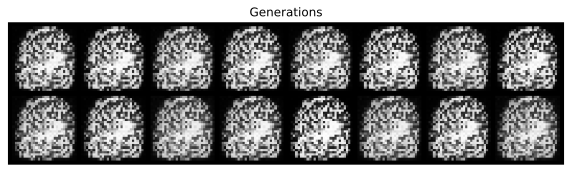

Epoch: 1, discrimiantor fake error: 0.0338, discriminator real acc: 0.934
Epoch: 2, discrimiantor fake error: 0.0211, discriminator real acc: 0.958
Epoch: 3, discrimiantor fake error: 0.00456, discriminator real acc: 0.98
Epoch: 4, discrimiantor fake error: 0.00242, discriminator real acc: 0.991
Epoch: 5, discrimiantor fake error: 0.00135, discriminator real acc: 0.995
Epoch: 6, discrimiantor fake error: 0.00192, discriminator real acc: 0.997
Epoch: 7, discrimiantor fake error: 0.00311, discriminator real acc: 0.996
Epoch: 8, discrimiantor fake error: 0.00995, discriminator real acc: 0.992
Epoch: 9, discrimiantor fake error: 0.0217, discriminator real acc: 0.98
Epoch: 10, discrimiantor fake error: 0.0184, discriminator real acc: 0.979


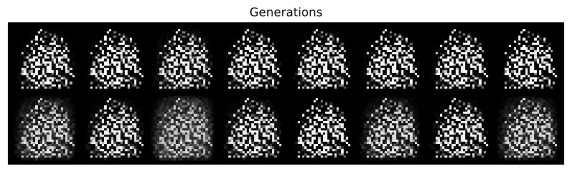

Epoch: 11, discrimiantor fake error: 0.00942, discriminator real acc: 0.988
Epoch: 12, discrimiantor fake error: 0.00618, discriminator real acc: 0.991
Epoch: 13, discrimiantor fake error: 0.0108, discriminator real acc: 0.989
Epoch: 14, discrimiantor fake error: 0.0426, discriminator real acc: 0.971
Epoch: 15, discrimiantor fake error: 0.0428, discriminator real acc: 0.958
Epoch: 16, discrimiantor fake error: 0.0213, discriminator real acc: 0.972
Epoch: 17, discrimiantor fake error: 0.0205, discriminator real acc: 0.977
Epoch: 18, discrimiantor fake error: 0.0301, discriminator real acc: 0.972
Epoch: 19, discrimiantor fake error: 0.037, discriminator real acc: 0.96


KeyboardInterrupt: 

In [12]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [19]:
print(f"Num params: {sum([param.nelement() for param in generator.parameters()])}")

Num params: 275728


## Stwórzmy model warunkowany klasą
Może się przydać F.one_hot

# Ewaluacja modeli generatywnych

In [27]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [28]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [29]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [30]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(test_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  87.02 % of the dataset


In [31]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
    # generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    generations_gan = generator(fixed_noise)
    # generations_vae = vae.decoder(fixed_noise)

In [32]:
orig_data = [x[0] for x in list(test_set)[:1000]]
orig_data = torch.cat(orig_data)

In [33]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    # dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()
    # dist_cond_gan = evaluator.get_features(generations_cond_gan.to(device)).cpu()

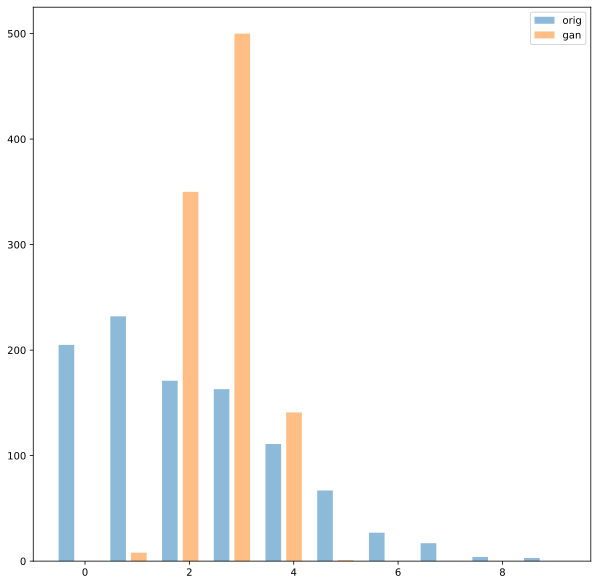

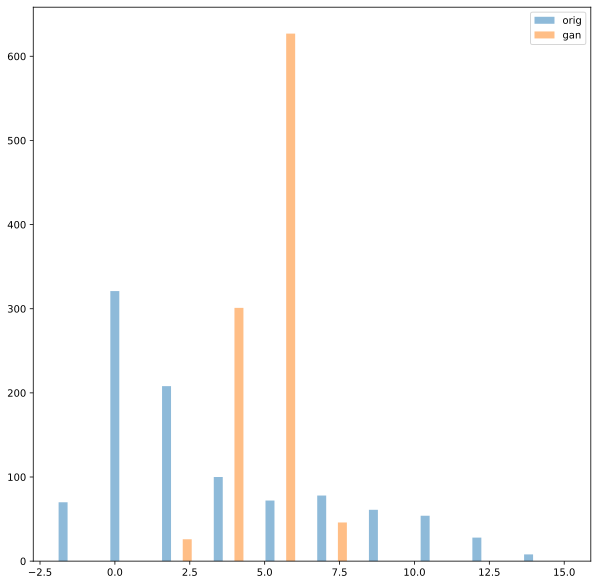

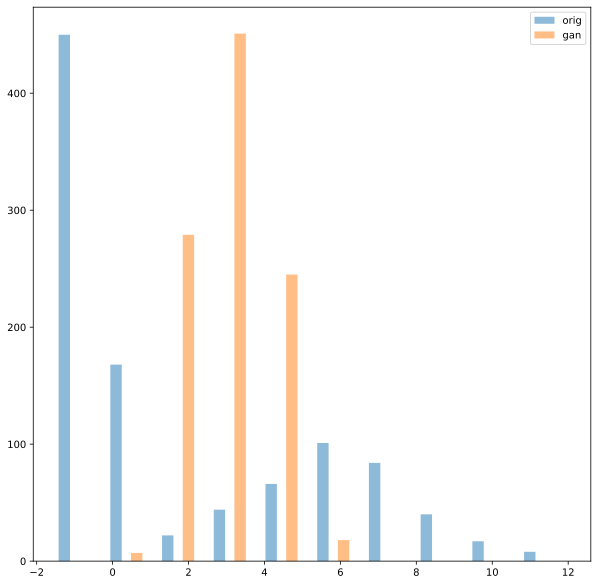

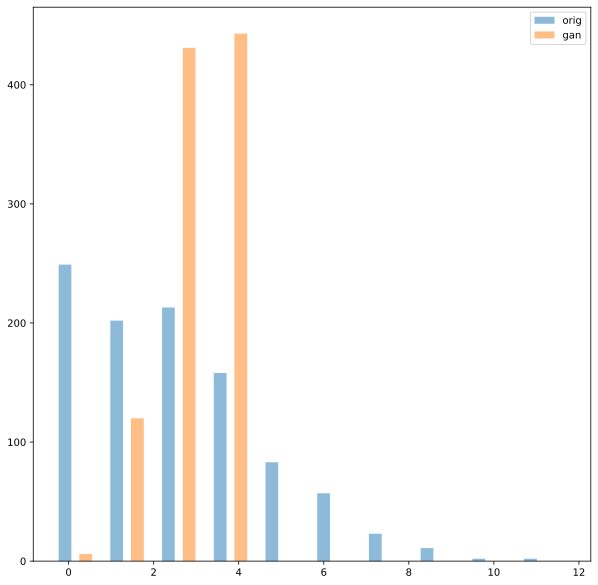

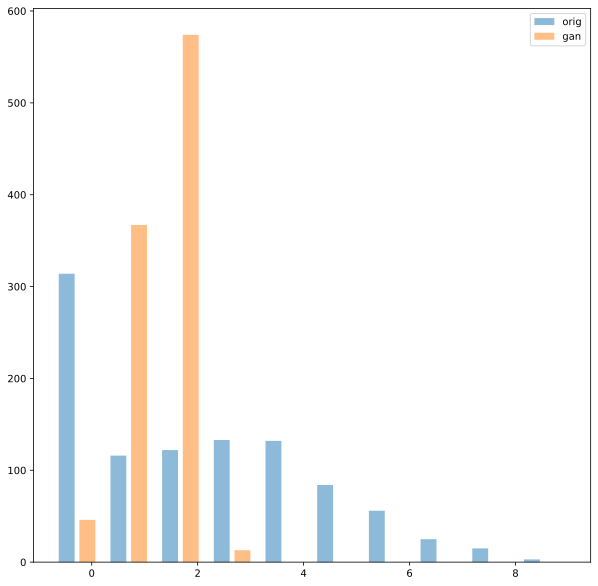

In [34]:
for idx in range(5):
    bins = 10
    w = 0.3
    plt.figure(figsize=(10,10))
    # plt.hist([dist_orig_data[:,idx].numpy(),dist_vae[:,idx].numpy(),dist_gan[:,idx], dist_cond_gan[:,idx]], bins, alpha=0.5, label=['orig','vae','gan','cond_gan'],width=w)
    plt.hist([dist_orig_data[:,idx].numpy(),dist_gan[:,idx]], bins, alpha=0.5, label=['orig','gan'],width=w)
    plt.legend(loc='upper right')
    plt.show();
    plt.close()

In [35]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [36]:
orig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [37]:
# for name, obj in zip(['orig','vae','gan','cond_gan'],[dist_orig_data_2.numpy(),dist_vae.numpy(),dist_gan.numpy(), dist_cond_gan.numpy()]):
for name, obj in zip(['orig', 'gan'],[dist_orig_data_2.numpy(),dist_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: 1.8406806197092465
FD gan: 297.07118339914376
